<a href="https://colab.research.google.com/github/d4rkl0rd3r3b05/AI_ML/blob/main/House_Price_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Integrating Kaggle with collab

In [42]:
from pathlib import Path

# installing kaggle package
if not(Path("kaggle.json").is_file()):
  !pip install -q kaggle

  # importing kaggle api file
  from google.colab import files
  files.upload()

  !mkdir ~/.kaggle
  !cp kaggle.json ~/.kaggle/

  !chmod 600 ~/.kaggle/kaggle.json

# making res call from kaggle
!kaggle datasets list -s "home-data-for-ml-course"

ref                                                               title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
dansbecker/home-data-for-ml-course                                home data for ml course                             94KB  2019-01-23 00:45:18          20256        224  0.3529412        
estrotococo/home-data-for-ml-course                               home data for ml course                            195KB  2019-08-27 23:28:02            409         16  0.64705884       
dorami/homedataformlcourse                                        home-data-for-ml-course                            179KB  2020-11-02 21:19:29             50          2  0.1764706        
dsposeidon/homedataformlcourse                         

## Packages Import

In [43]:
## Install missing packages
!pip install -q torchmetrics

try:
  import torchinfo
except:
  !pip install -q torchinfo

from torchinfo import summary

In [44]:
# torch essentials
import torch
from torch import nn
from torch import optim

# basic ops
import math
import numpy as np
from pathlib import Path
import requests


# util packages
from torch.utils.data import DataLoader, Dataset
from timeit import default_timer as timer
from tqdm.auto import tqdm
from sklearn.preprocessing import StandardScaler


# Torch metric
from torchmetrics import Accuracy

## Step 1 - Downloading the train and test data from Kaggle

In [45]:
if not(Path("home-data-for-ml-course.zip").is_file()):
  !kaggle competitions download -c 'home-data-for-ml-course'
  !unzip "home-data-for-ml-course.zip" -d "sample_data/home-data-for-ml-course"

## Step 2 - Analyze the train data

### Step 2.1 - Create dataframes from the data csv

In [46]:
import pandas as pd


train_data_path = Path("sample_data/home-data-for-ml-course/train.csv")
test_data_path = Path("sample_data/home-data-for-ml-course/test.csv")

train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

train_data.head(), test_data.head(), train_data.columns

(   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
 0   1          60       RL         65.0     8450   Pave   NaN      Reg   
 1   2          20       RL         80.0     9600   Pave   NaN      Reg   
 2   3          60       RL         68.0    11250   Pave   NaN      IR1   
 3   4          70       RL         60.0     9550   Pave   NaN      IR1   
 4   5          60       RL         84.0    14260   Pave   NaN      IR1   
 
   LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
 0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
 1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
 2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
 3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
 4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   
 
   YrSold  SaleType  SaleCondition  SalePrice  
 0   2

### Step 2.2 - Describe data

In [47]:
train_data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000



## Step 3 - Preprocess the train data(including split the train data in test-train)

In [48]:
from sklearn.model_selection import train_test_split

# Select features and target
features = ['LotArea', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd'] #train_data.columns
target = 'SalePrice'

# Handle missing values (replace with mean for simplicity)
for feature in features:
    if train_data[feature].isnull().any() and feature != "SalePrice":
        train_data[feature].fillna(train_data[feature].mean(), inplace=True)

X_train, X_test, y_train, y_test = train_test_split(train_data.loc[:, features], train_data[["SalePrice"]],test_size=0.33, random_state=42)

# Scale numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

### Step 3.2 - Create Dataset and DataLoader

In [67]:
class HousePricePredictorDataset(Dataset):
  def __init__(self, house_data, sale_price):
    super().__init__()

    self.house_data = house_data
    self.sale_price = sale_price

  def __getitem__(self, index):
    return torch.tensor(self.house_data[index], dtype=torch.float32), torch.tensor(self.sale_price[index], dtype=torch.float32)

  def __len__(self):
    return len(self.house_data)



train_dataset_custom = HousePricePredictorDataset(house_data=X_train, sale_price=y_train)
test_dataset_custom = HousePricePredictorDataset(house_data=X_test, sale_price=y_test)

train_dataloader_custom = DataLoader(dataset=train_dataset_custom, batch_size=3, shuffle=False)
test_dataloader_custom = DataLoader(dataset=test_dataset_custom, batch_size=3, shuffle=False)

## Step 4 - Define a model class, optimizer and criterion

In [50]:
class HousePricePredictor(nn.Module):
    def __init__(self, input_features, hidden_nodes=8):
        super(HousePricePredictor, self).__init__()
        self.linear = nn.Sequential(nn.Linear(in_features=input_features, out_features=hidden_nodes),
                               nn.ReLU(),
                               nn.Linear(in_features=hidden_nodes, out_features=hidden_nodes),
                               nn.ReLU(),
                               nn.Dropout(0.2),
                               nn.Linear(in_features=hidden_nodes, out_features=1))

    def forward(self, x):
        return self.linear(x)

model = HousePricePredictor(input_features=len(features))

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Step 5 - Train model

### Step 5.1 - Deine Train and Evaluation loops

In [51]:
# Training Loop
def train_step(model: nn.Module,
               criterion: nn.Module,
               optimizer: torch.optim.Optimizer,
               dataloader: torch.utils.data.DataLoader):

  total_loss= 0.0
  for batch, (X,y) in tqdm(enumerate(dataloader),total=len(dataloader)):
    model.train()

    pred = model(X)

    loss = criterion(pred, y)

    total_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 200 == 0:
      print(f"Training for Batch: {batch} | Loss: {loss}")

  avg_loss = total_loss/len(dataloader)
  print(f"Training complete with Average Total Loss: {avg_loss}" )

  return avg_loss

# Testing Loop
def test_step(model: nn.Module,
              criterion: nn.Module,
              dataloader: torch.utils.data.DataLoader):

  model.eval()
  with torch.inference_mode():
    total_loss = 0
    predictions = []
    for batch, (X,y) in tqdm(enumerate(dataloader),total=len(dataloader)):
        pred = model(X)
        predictions.append(pred)


        loss = criterion(pred, y)

        total_loss += loss.item()

    avg_loss = total_loss/len(dataloader)
    print(f"Testing complete with Average Total Loss: {avg_loss}" )

    return (avg_loss, predictions)

### Step 5.2 - Execute train and evaluation loops[link text](https://)

In [52]:
EPOCH = 20

start_time = timer()

total_train_loss = 0
total_test_loss = 0

#Create empty results dictionary
results = {"train_loss": [],
    "test_loss": [],
}

for index in range(EPOCH):
  total_train_loss = train_step(model,
                                      criterion = criterion,
                                      optimizer=optimizer,
                                      dataloader=train_dataloader_custom)

  total_test_loss, predictions = test_step(model,
                                                criterion = criterion,
                                                dataloader=test_dataloader_custom)

  results["train_loss"].append(total_train_loss.item() if isinstance(total_train_loss, torch.Tensor) else total_train_loss)
  results["test_loss"].append(total_test_loss.item() if isinstance(total_test_loss, torch.Tensor) else total_test_loss)


end_time = timer()

print(f"Modelling complete in {end_time-start_time}")
print(f"Train Results: Train Total Loss: {total_train_loss}" )
print(f"Train Results: Test Total Loss: {total_test_loss}" )

  0%|          | 0/326 [00:00<?, ?it/s]

Training for Batch: 0 | Loss: 0.3612086772918701
Training for Batch: 200 | Loss: 0.09365653991699219
Training complete with Average Total Loss: 0.825311772635298


  0%|          | 0/161 [00:00<?, ?it/s]

Testing complete with Average Total Loss: 0.7368706460920689


  0%|          | 0/326 [00:00<?, ?it/s]

Training for Batch: 0 | Loss: 0.13962890207767487
Training for Batch: 200 | Loss: 0.16921161115169525
Training complete with Average Total Loss: 0.4701092573092748


  0%|          | 0/161 [00:00<?, ?it/s]

Testing complete with Average Total Loss: 0.4683512708368156


  0%|          | 0/326 [00:00<?, ?it/s]

Training for Batch: 0 | Loss: 0.08360614627599716
Training for Batch: 200 | Loss: 0.1738637089729309
Training complete with Average Total Loss: 0.4346043484662574


  0%|          | 0/161 [00:00<?, ?it/s]

Testing complete with Average Total Loss: 0.39143694487294783


  0%|          | 0/326 [00:00<?, ?it/s]

Training for Batch: 0 | Loss: 0.12935370206832886
Training for Batch: 200 | Loss: 0.1342283934354782
Training complete with Average Total Loss: 0.36203058054967086


  0%|          | 0/161 [00:00<?, ?it/s]

Testing complete with Average Total Loss: 0.3440805717041681


  0%|          | 0/326 [00:00<?, ?it/s]

Training for Batch: 0 | Loss: 0.05837227776646614
Training for Batch: 200 | Loss: 0.16144271194934845
Training complete with Average Total Loss: 0.3396042553173018


  0%|          | 0/161 [00:00<?, ?it/s]

Testing complete with Average Total Loss: 0.3198148376938904


  0%|          | 0/326 [00:00<?, ?it/s]

Training for Batch: 0 | Loss: 0.03439636528491974
Training for Batch: 200 | Loss: 0.07103580981492996
Training complete with Average Total Loss: 0.3135307528617066


  0%|          | 0/161 [00:00<?, ?it/s]

Testing complete with Average Total Loss: 0.30170947853627655


  0%|          | 0/326 [00:00<?, ?it/s]

Training for Batch: 0 | Loss: 0.08897390216588974
Training for Batch: 200 | Loss: 0.13312308490276337
Training complete with Average Total Loss: 0.2733683851876073


  0%|          | 0/161 [00:00<?, ?it/s]

Testing complete with Average Total Loss: 0.2774591298436931


  0%|          | 0/326 [00:00<?, ?it/s]

Training for Batch: 0 | Loss: 0.06265457719564438
Training for Batch: 200 | Loss: 0.1017320454120636
Training complete with Average Total Loss: 0.3079513660360676


  0%|          | 0/161 [00:00<?, ?it/s]

Testing complete with Average Total Loss: 0.27735432717003367


  0%|          | 0/326 [00:00<?, ?it/s]

Training for Batch: 0 | Loss: 0.07975595444440842
Training for Batch: 200 | Loss: 0.15304146707057953
Training complete with Average Total Loss: 0.2699085495836799


  0%|          | 0/161 [00:00<?, ?it/s]

Testing complete with Average Total Loss: 0.2648509318736253


  0%|          | 0/326 [00:00<?, ?it/s]

Training for Batch: 0 | Loss: 0.043627411127090454
Training for Batch: 200 | Loss: 0.15445275604724884
Training complete with Average Total Loss: 0.3215222381665286


  0%|          | 0/161 [00:00<?, ?it/s]

Testing complete with Average Total Loss: 0.2736075734466557


  0%|          | 0/326 [00:00<?, ?it/s]

Training for Batch: 0 | Loss: 0.12847907841205597
Training for Batch: 200 | Loss: 0.12873367965221405
Training complete with Average Total Loss: 0.31032940799740366


  0%|          | 0/161 [00:00<?, ?it/s]

Testing complete with Average Total Loss: 0.2746125979765509


  0%|          | 0/326 [00:00<?, ?it/s]

Training for Batch: 0 | Loss: 0.02071407623589039
Training for Batch: 200 | Loss: 0.09641014784574509
Training complete with Average Total Loss: 0.285622297995081


  0%|          | 0/161 [00:00<?, ?it/s]

Testing complete with Average Total Loss: 0.27051708062059354


  0%|          | 0/326 [00:00<?, ?it/s]

Training for Batch: 0 | Loss: 0.07187966257333755
Training for Batch: 200 | Loss: 0.11535324901342392
Training complete with Average Total Loss: 0.2899849527191222


  0%|          | 0/161 [00:00<?, ?it/s]

Testing complete with Average Total Loss: 0.2738154847413498


  0%|          | 0/326 [00:00<?, ?it/s]

Training for Batch: 0 | Loss: 0.028192972764372826
Training for Batch: 200 | Loss: 0.09849230200052261
Training complete with Average Total Loss: 0.2551342668426023


  0%|          | 0/161 [00:00<?, ?it/s]

Testing complete with Average Total Loss: 0.2663260249940531


  0%|          | 0/326 [00:00<?, ?it/s]

Training for Batch: 0 | Loss: 0.020327763631939888
Training for Batch: 200 | Loss: 0.06521952152252197
Training complete with Average Total Loss: 0.3031861397810566


  0%|          | 0/161 [00:00<?, ?it/s]

Testing complete with Average Total Loss: 0.27522524474955146


  0%|          | 0/326 [00:00<?, ?it/s]

Training for Batch: 0 | Loss: 0.08396060019731522
Training for Batch: 200 | Loss: 0.11187714338302612
Training complete with Average Total Loss: 0.28903758876701313


  0%|          | 0/161 [00:00<?, ?it/s]

Testing complete with Average Total Loss: 0.26967781284890535


  0%|          | 0/326 [00:00<?, ?it/s]

Training for Batch: 0 | Loss: 0.045729052275419235
Training for Batch: 200 | Loss: 0.19739492237567902
Training complete with Average Total Loss: 0.25964552059607504


  0%|          | 0/161 [00:00<?, ?it/s]

Testing complete with Average Total Loss: 0.2608889326180609


  0%|          | 0/326 [00:00<?, ?it/s]

Training for Batch: 0 | Loss: 0.06465281546115875
Training for Batch: 200 | Loss: 0.21305488049983978
Training complete with Average Total Loss: 0.27966844446191486


  0%|          | 0/161 [00:00<?, ?it/s]

Testing complete with Average Total Loss: 0.2703327806196494


  0%|          | 0/326 [00:00<?, ?it/s]

Training for Batch: 0 | Loss: 0.06887733936309814
Training for Batch: 200 | Loss: 0.1963280290365219
Training complete with Average Total Loss: 0.2697929461353438


  0%|          | 0/161 [00:00<?, ?it/s]

Testing complete with Average Total Loss: 0.2654282558255291


  0%|          | 0/326 [00:00<?, ?it/s]

Training for Batch: 0 | Loss: 0.04858480766415596
Training for Batch: 200 | Loss: 0.07914949208498001
Training complete with Average Total Loss: 0.2724961488217721


  0%|          | 0/161 [00:00<?, ?it/s]

Testing complete with Average Total Loss: 0.25928210465509377
Modelling complete in 54.335804765999455
Train Results: Train Total Loss: 0.2724961488217721
Train Results: Test Total Loss: 0.25928210465509377


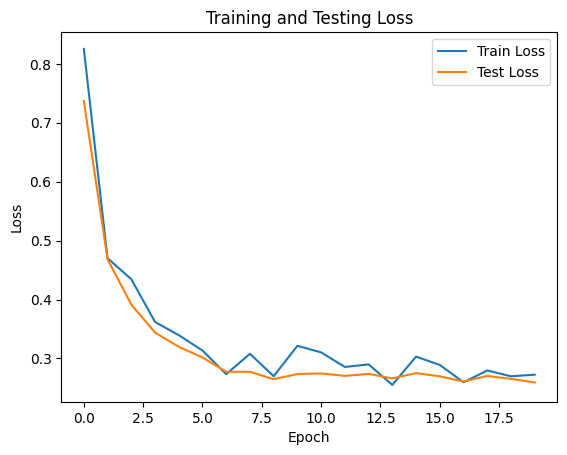

In [53]:
import matplotlib.pyplot as plt

plt.plot(results["train_loss"], label='Train Loss')
plt.plot(results["test_loss"], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.show()

## Step 6 - Make prediction

In [74]:
def predict_price(model, dataloader):
    model.eval()
    predictions = []
    with torch.no_grad():
      for batch, (features,_) in enumerate(response_dataloader):
            preds = model(features)
            predictions.extend(preds.squeeze().tolist())
    return predictions

response_dataset = HousePricePredictorDataset(house_data=test_data.loc[:, features].to_numpy(), sale_price=np.zeros(len(test_data)))
response_dataloader = DataLoader(response_dataset, batch_size=32, shuffle=False)

predicted_prices = predict_price(model, response_dataloader)

## Step 7 - Post Process the prediction in the required format for submission

In [75]:
submission_df = pd.DataFrame({'Id': test_data['Id'], 'SalePrice': predicted_prices})
submission_df.to_csv('submission.csv', index=False)